In [5]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import numpy as np
from os import path
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import colors

In [6]:
def normalize(ar):    
    shifted=ar - np.min(ar)
    normalized=shifted / np.max(shifted)    
    return normalized

In [7]:
def show(ar):
    print(ar.shape)
    plt.imshow(ar)

(320, 330, 3)


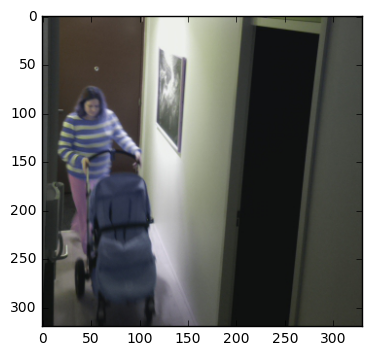

In [8]:
base_path='/media/chris/data/documents/chris/images/annotation/person/'
img_path = path.join(base_path,'wysmyjnq004867.jpg')
size = 320
def load_ar(img_path, returnNormalized=True):
    img = image.load_img(img_path, target_size=(480, 640))    
    r = 160
    c = 150
    if returnNormalized:
        ar = normalize(image.img_to_array(img)[r:r+size,c:r+size])
    else:
        ar = image.img_to_array(img)[r:r+size,c:r+size]
    return ar
show(load_ar(img_path))

### Make patches for annotation

In [35]:
import os
step = 32  #vgg16
size_r = 128 
size_c = 64
out_path='/media/chris/data/documents/chris/images/annotation/patches/new'
base_path='/media/chris/data/documents/chris/images/annotation/selected/new'
dirs = os.walk(base_path)
for dir in dirs:
    
    for file_name in dir[2]:        
        img_path = path.join(base_path,file_name)
        ar = load_ar(img_path)
        for r in range(0,size-size_r,step):
            for c in range(0,size-size_c,step):
                if r != 0 or c != 96:
                    pass #continue
                crop = ar[r:r+size_r,c:c+size_c]
                #show(crop)
                out_file_name = '_'.join([file_name,str(r),str(c)]) + '.png'
                plt.imsave(path.join(out_path, out_file_name), crop, format='png')

### Create generators

First create a test generator to find the right transformation settings.

In [36]:
#gen_test_gen = image.ImageDataGenerator(horizontal_flip=True, zoom_range=0.05, height_shift_range=0.01, width_shift_range=0.01)
gen_test_gen = image.ImageDataGenerator()
gen_test = gen_test_gen.flow_from_directory('/media/chris/data/documents/chris/images/annotation/patches/gentest', target_size=(64,32), shuffle=False)

Found 1 images belonging to 1 classes.


(1, 1)
(64, 32, 3)


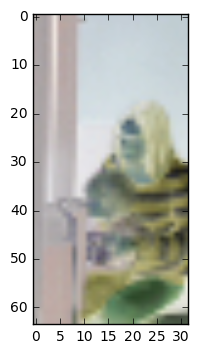

In [41]:
for im in gen_test:
    print(im[1].shape)
    show(im[0][0])
    break

Now define training and validation generators

In [48]:
val_gen = image.ImageDataGenerator()
validation = val_gen.flow_from_directory('/media/chris/data/documents/chris/images/annotation/patches/validation', target_size=(64,32), shuffle=False)

Found 20 images belonging to 2 classes.


In [49]:
train_gen = image.ImageDataGenerator(horizontal_flip=True, zoom_range=0.05, height_shift_range=0.01, width_shift_range=0.01)
train = train_gen.flow_from_directory('/media/chris/data/documents/chris/images/annotation/patches/train', target_size=(64,32))

Found 334 images belonging to 2 classes.


### Define a model

In [54]:
from keras.models import Sequential
from keras.layers import BatchNormalization, Conv2D, MaxPool2D, Activation, Flatten
from keras.optimizers import Adam
from keras.regularizers import l2
outputdim = 2  # number of classes
weightinit = 'lecun_uniform'  # weight initialization
regularization_rate=0.01
model = Sequential()
model.add(
    BatchNormalization(
        input_shape=(            
            64,32, 3)))
model.add(Conv2D(16, 3, padding='same',
                            kernel_regularizer=l2(regularization_rate),
                            kernel_initializer=weightinit))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D())
model.add(Conv2D(16, 3, padding='same',
                            kernel_regularizer=l2(regularization_rate),
                            kernel_initializer=weightinit))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(MaxPool2D())
# model.add(Conv2D(16, 3, padding='same',
#                             kernel_regularizer=l2(regularization_rate),
#                             kernel_initializer=weightinit))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D())
model.add(Conv2D(16, 3, padding='same',
                            kernel_regularizer=l2(regularization_rate),
                            kernel_initializer=weightinit))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D())
model.add(Conv2D(16, 3, padding='same',
                            kernel_regularizer=l2(regularization_rate),
                            kernel_initializer=weightinit))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D())
model.add(Conv2D(16, 3, padding='same',
                            kernel_regularizer=l2(regularization_rate),
                            kernel_initializer=weightinit))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D())
model.add(Conv2D(32, 3, padding='same',
                            kernel_regularizer=l2(regularization_rate),
                            kernel_initializer=weightinit))
model.add(BatchNormalization())
model.add(Activation('relu'))
#model.add(MaxPool2D())
model.add(Conv2D(2, (2,1), padding='valid',
                            kernel_regularizer=l2(regularization_rate),
                            kernel_initializer=weightinit))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Activation("softmax")) # Final classification layer
learning_rate=0.001

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=learning_rate),
              metrics=['accuracy'])


In [46]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_54 (Batc (None, 64, 32, 3)         12        
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 64, 32, 16)        448       
_________________________________________________________________
batch_normalization_55 (Batc (None, 64, 32, 16)        64        
_________________________________________________________________
activation_48 (Activation)   (None, 64, 32, 16)        0         
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 32, 16, 16)        0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 32, 16, 16)        2320      
_________________________________________________________________
batch_normalization_56 (Batc (None, 32, 16, 16)        64        
__________

In [56]:
history = model.fit_generator(generator=train, validation_data=validation, validation_steps=20, steps_per_epoch=100, epochs=10)

Epoch 1/20
100/100 [==============================] - 11s - loss: 1.2844 - acc: 0.8946 - val_loss: 1.4829 - val_acc: 0.5000
Epoch 2/20
100/100 [==============================] - 11s - loss: 0.9448 - acc: 0.9733 - val_loss: 1.2733 - val_acc: 0.5500
Epoch 3/20
100/100 [==============================] - 11s - loss: 0.7565 - acc: 0.9921 - val_loss: 1.0535 - val_acc: 0.6500
Epoch 4/20
100/100 [==============================] - 11s - loss: 0.6222 - acc: 0.9920 - val_loss: 0.9070 - val_acc: 0.6500
Epoch 5/20
100/100 [==============================] - 11s - loss: 0.5253 - acc: 0.9914 - val_loss: 0.6927 - val_acc: 0.9000
Epoch 6/20
100/100 [==============================] - 11s - loss: 0.4200 - acc: 0.9987 - val_loss: 0.7433 - val_acc: 0.7500
Epoch 7/20
100/100 [==============================] - 11s - loss: 0.3511 - acc: 0.9967 - val_loss: 0.5281 - val_acc: 0.9000
Epoch 8/20
100/100 [==============================] - 11s - loss: 0.3170 - acc: 0.9894 - val_loss: 0.3365 - val_acc: 1.0000
Epoch 9/

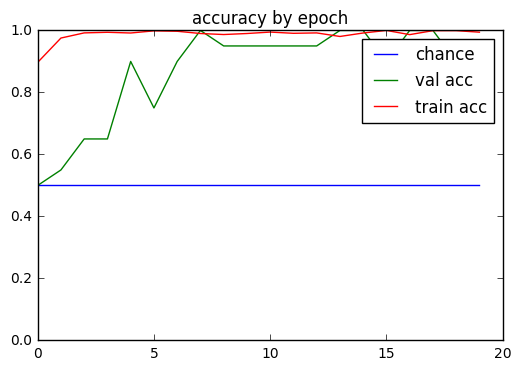

In [57]:
plt.title('accuracy by epoch')
plt.plot(np.zeros(len(history.history['acc'])) + 0.5, label='chance')
plt.plot(history.history['val_acc'], label='val acc')
plt.plot(history.history['acc'], label='train acc')
plt.ylim(0,1)
plt.legend()

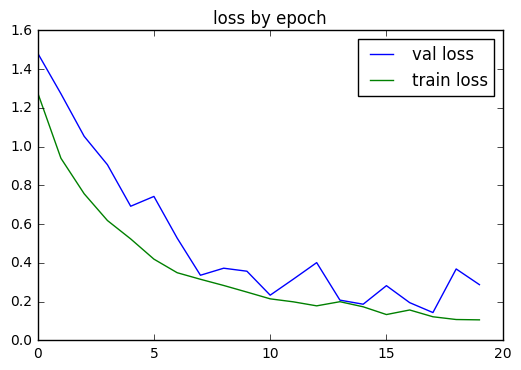

In [58]:
plt.title('loss by epoch')
plt.plot(history.history['val_loss'], label='val loss')
plt.plot(history.history['loss'], label='train loss')
plt.legend()

In [61]:
model.save('/media/chris/data/documents/chris/images/annotation/person/model.h5')

### Finetune VGG16

In [61]:
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Input
base_model = VGG16(include_top=False, weights='imagenet', input_tensor=Input((128,64,3)))
for layer in base_model.layers:
    layer.trainable = False
x = base_model.output
x = MaxPool2D()(x)
x = Conv2D(2, (2,1), padding='valid',
                         kernel_regularizer=l2(regularization_rate),
                        kernel_initialization=weightinit)(x)
x = Flatten(name='flatten')(x)
x = Activation("softmax")(x)
vggmodel = Model(input=base_model.input, output=x)
vggmodel.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=learning_rate),
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        (None, 128, 64, 3)        0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 64, 64)       1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 64, 64)       36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 16, 128)       0         
__________

/home/chris/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:20: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(2, (2, 1), kernel_initializer="lecun_uniform", padding="valid", kernel_regularizer=<keras.reg...)`
/home/chris/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("ac..., inputs=Tensor("in...)`


In [ ]:
vggmodel.summary()

In [62]:
history = model.fit_generator(generator=train, validation_data=validation, validation_steps=20, steps_per_epoch=100, epochs=1400)

Epoch 1/1400
100/100 [==============================] - 214s - loss: 8.4204 - acc: 0.4764 - val_loss: 8.1353 - val_acc: 0.5000
Epoch 2/1400
100/100 [==============================] - 213s - loss: 8.3219 - acc: 0.4880 - val_loss: 8.1217 - val_acc: 0.5000
Epoch 3/1400
100/100 [==============================] - 212s - loss: 8.3098 - acc: 0.4880 - val_loss: 8.1109 - val_acc: 0.5000
Epoch 4/1400
100/100 [==============================] - 213s - loss: 8.3001 - acc: 0.4880 - val_loss: 8.1021 - val_acc: 0.5000
Epoch 5/1400
100/100 [==============================] - 212s - loss: 8.3980 - acc: 0.4814 - val_loss: 8.0950 - val_acc: 0.5000
Epoch 6/1400
100/100 [==============================] - 212s - loss: 8.4470 - acc: 0.4780 - val_loss: 8.0893 - val_acc: 0.5000
Epoch 7/1400
 53/100 [==============>...............] - ETA: 88s - loss: 8.2210 - acc: 0.4917

KeyboardInterrupt: 

In [ ]:
model.predict()